In [1]:
import astropy.io.fits as fits
import des_functions
import treecorr
import numpy as np
import matplotlib.pyplot as plt
from more_itertools import locate
import time
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['cmr10']
plt.rcParams['mathtext.fontset'] ='cm'
data_dir = '/home/b7009348/WGL_project/DES-data/'

In [2]:
# define bin and scale params
nbins=20
npatches=20
theta_min=2.5
theta_max=250

In [3]:
# paths to required files
lens_file = 'DES_Y1A1_Lenses_z=0.3-0.45.fits'
source_Zs = 'mof_BPZ_(stacking).fits'
im3_file = 'y1_im3_shapes_matched.fits'
mcal_file = 'y1_mcal_shapes_matched.fits'

In [4]:
def im3_tangential_shear(cat_l, cat_s, cat_r, cat_k, nbins):
    
    gammat = np.zeros([nbins])
    theta = np.zeros_like(gammat)
    
    # do correlations with lenese, NKCorrelation is used to apply multiplicative correction
    ng = treecorr.NGCorrelation(nbins=nbins, min_sep=theta_min, max_sep=theta_max, sep_units='arcmin')
    ng.process(cat_l, cat_s)
    nk = treecorr.NKCorrelation(nbins=nbins, min_sep=theta_min, max_sep=theta_max, sep_units='arcmin')
    nk.process(cat_l, cat_k)
    
    # do correlations with randoms
    rg = treecorr.NGCorrelation(nbins=nbins, min_sep=theta_min, max_sep=theta_max, sep_units='arcmin')
    rg.process(cat_r, cat_s)
    rk = treecorr.NKCorrelation(nbins=nbins, min_sep=theta_min, max_sep=theta_max, sep_units='arcmin')
    rk.process(cat_r, cat_k)
    
    # correlation functions and corrections for lenses and randoms
    xi_l = ng.xi
    sens_l = nk.xi
    xi_r = rg.xi
    sens_r = rk.xi
    
    # store data in preallocated arrays
    gammat = xi_l/sens_l - xi_r/sens_r
    theta = np.exp(ng.meanlogr)
    
    del ng, rg, nk, rk, xi_l, sens_l, xi_r, sens_r
    
    return gammat, theta

def calculate_boost(cat_l, cat_s, cat_r, nbins):
    
    boost = np.zeros([nbins])
    
    # do count correlations to find boost
    ls = treecorr.NNCorrelation(nbins=nbins, min_sep=theta_min, max_sep=theta_max, sep_units='arcmin')
    ls.process(cat_l, cat_s)

    rs = treecorr.NNCorrelation(nbins=nbins, min_sep=theta_min, max_sep=theta_max, sep_units='arcmin')
    rs.process(cat_r, cat_s)
    
    nrand = cat_r.nobj
    nlens = cat_l.nobj
    
    boost = nrand/nlens * ls.weight/rs.weight
    
    del ls, rs, nrand, nlens
    
    return boost

def mcal_tangential_shear(cat_l, cat_s, cat_r, nbins, R):
    
    gammat = np.zeros([nbins])
    theta = np.zeros_like(gammat)
    
    # do correlations with lenses
    ng = treecorr.NGCorrelation(nbins=nbins, min_sep=theta_min, max_sep=theta_max, sep_units='arcmin')
    ng.process(cat_l, cat_s)
    
    # do correlations with randoms
    rg = treecorr.NGCorrelation(nbins=nbins, min_sep=theta_min, max_sep=theta_max, sep_units='arcmin')
    rg.process(cat_r, cat_s)
    
    # correlation functions and corrections for lenses and randoms
    xi_l = ng.xi
    xi_r = rg.xi
    
    # store data in preallocated arrays
    gammat = 1.0/R * (xi_l - xi_r)
    theta = np.exp(ng.meanlogr)
    
    del ng, rg, xi_l, xi_r
    
    return gammat, theta

In [11]:
lens_file = 'DES_Y1A1_Lenses_z=0.3-0.45.fits'
source_Zs = 'mof_BPZ_(stacking).fits'
im3_file = 'y1_im3_shapes_matched.fits'
mcal_file = 'y1_mcal_shapes_matched.fits'

IA_signal = np.zeros([npatches, nbins])
theta = np.zeros_like(IA_signal)

# read in lens data and create treecorr catalogue object to store
with fits.open(data_dir+lens_file) as hdu:
    data = hdu[1].data
    ra_l = data['RA']
    dec_l = data['DEC']
    w_l = data['weight']
    
# pass in npatch arguement to create catalogue using patches    
cat_l = treecorr.Catalog(ra=ra_l, dec=dec_l, ra_units='deg', dec_units='deg', w=w_l, npatch=npatches)

del data, ra_l, dec_l, w_l

# read in randoms data and create treecorr catalogue
with fits.open(data_dir+'DES_Y1A1_3x2pt_redMaGiC_RANDOMS.fits') as hdu:
    data = hdu[1].data
    indexes = list(locate(data['z'], lambda x: 0.3 < x < 0.45)) # cut randoms to same redshift as lenses 
    ra_r = data['RA'][indexes]
    dec_r = data['dec'][indexes]
    rand_z = data['z'][indexes]

# define patches based on patches from lens catalogue so all catalogues use the same patches    
cat_r = treecorr.Catalog(ra=ra_r, dec=dec_r, ra_units='deg', dec_units='deg', r=rand_z, patch_centers=cat_l.patch_centers)

del data, ra_r, dec_r, indexes, rand_z

with fits.open(data_dir+mcal_file) as hdu:
    data = hdu[1].data
    ra_s = data['ra']
    dec_s = data['dec']
    e1 = data['e1']
    e2 = data['e2']
    R11 = data['R11'] # e1-e1

cat_mcal = treecorr.Catalog(ra=ra_s, dec=dec_s, ra_units='deg', dec_units='deg', r=R11, g1=e1, g2=e2, patch_centers=cat_l.patch_centers)

del data, ra_s, dec_s, e1, e2, R11

with fits.open(data_dir+im3_file) as hdu:
    data = hdu[1].data
    im3_ID = data['coadd_objects_id']
    ra_s = data['ra']
    dec_s = data['dec']
    e1 = data['e1'] - data['c1']
    e2 = data['e2'] - data['c2']
    sens = data['m'] + 1.0
    w = data['weight']
del data

# load in z_mc for all sources
with fits.open(data_dir+source_Zs) as hdu:
    data = hdu[1].data
    im3_zmc = data['z_mc']
    zmc_ID = data['coadd_objects_id']
del data

# match z_mc values to source IDs
matches, zmc_indices, shape_indices = np.intersect1d(zmc_ID, im3_ID, return_indices=True)

# slice z_mc values to only to those in matched catalogue
im3_zmc = im3_zmc[zmc_indices]

# delete uneccessary arrays
del matches, zmc_indices, shape_indices, zmc_ID, im3_ID

cat_im3 = treecorr.Catalog(ra=ra_s, dec=dec_s, ra_units='deg', dec_units='deg', r=im3_zmc, g1=e1, g2=e2, w=w, patch_centers=cat_l.patch_centers)
cat_k = treecorr.Catalog(ra=ra_s, dec=dec_s, ra_units='deg', dec_units='deg', k=sens, w=w, patch_centers=cat_l.patch_centers)

del ra_s, dec_s, w, e1, e2, sens, im3_zmc

print('ALL CATALOGUES READY')

#loop to exclude 1 patch at a time
print('Beginning Jackknife estimate...')
for i in range(npatches):
    
    im3_gammat = np.zeros([nbins])
    im3_theta = np.zeros_like(im3_gammat)
    mcal_gammat = np.zeros_like(im3_gammat)
    mcal_theta = np.zeros_like(im3_gammat)
    boost = np.zeros_like(im3_gammat)
    F = np.zeros_like(im3_gammat)
    
    start = time.time()
    
    #locate patch in catlogues
    l_indexes = list(locate(cat_l.patch, lambda x: x != i))
    r_indexes = list(locate(cat_r.patch, lambda x: x != i))
    mcal_indexes = list(locate(cat_mcal.patch, lambda x: x != i))
    im3_indexes = list(locate(cat_im3.patch, lambda x: x != i))
    k_indexes = list(locate(cat_k.patch, lambda x: x != i))
    
    print('Patch %g located...' %i)
    
    #create new catalogues with this patch missing
    jk_l = treecorr.Catalog(ra=cat_l.ra[l_indexes], dec=cat_l.dec[l_indexes], ra_units='rad', dec_units='rad', w=cat_l.w[l_indexes])
    
    jk_r = treecorr.Catalog(ra=cat_r.ra[r_indexes], dec=cat_r.dec[r_indexes], ra_units='rad', dec_units='rad')
    
    jk_mcal = treecorr.Catalog(ra=cat_mcal.ra[mcal_indexes], dec=cat_mcal.dec[mcal_indexes], ra_units='rad', dec_units='rad', g1=cat_mcal.g1[mcal_indexes], 
                                g2=cat_mcal.g2[mcal_indexes])
    
    jk_im3 = treecorr.Catalog(ra=cat_im3.ra[im3_indexes], dec=cat_im3.dec[im3_indexes], ra_units='rad', dec_units='rad', g1=cat_im3.g1[im3_indexes], 
                                g2=cat_im3.g2[im3_indexes], w=cat_im3.w[im3_indexes])
    
    jk_k = treecorr.Catalog(ra=cat_k.ra[k_indexes], dec=cat_k.dec[k_indexes], ra_units='rad', dec_units='rad', k=cat_k.k[k_indexes], 
                                w=cat_k.w[k_indexes])
    
    R = np.mean(cat_mcal.r[mcal_indexes])
    
    rand_z = cat_r.r[r_indexes]
    source_z = cat_im3.r[im3_indexes]
    source_weights = cat_im3.w[im3_indexes]
    
    print('Number of sources in patch: %f' %jk_im3.nobj)
    print('Total number of sources: %f' %cat_im3.nobj)
    
    del l_indexes, r_indexes, mcal_indexes, k_indexes, im3_indexes
    
    mcal_gammat[:], mcal_theta[:] = mcal_tangential_shear(cat_l=jk_l, cat_s=jk_mcal, cat_r=jk_r, nbins=nbins, R=R)
    
    print('mcal shear calculation complete...')
    print(mcal_gammat)
    
    im3_gammat[:], im3_theta[:] = im3_tangential_shear(cat_l=jk_l, cat_s=jk_im3, cat_r=jk_r, cat_k=jk_k, nbins=nbins)
    
    print('im3 shear calculation complete...')
    print(im3_gammat)
    
    boost[:] = calculate_boost(cat_l=jk_l, cat_s=jk_im3, cat_r=jk_r, nbins=nbins)
    
    print('boost calculation complete...')
    print(boost)
    
    F = des_functions.calculate_F(nbins=810, source_z=source_z, lens_z=rand_z, source_weights=source_weights)
    
    print('F calculation complete...')
    print(F)
    
    IA_signal[i,:] = (im3_gammat[:] - mcal_gammat[:]) / (boost[:] - 1.0 + F)
    print(IA_signal[i,:])
    
    end = time.time()
    diff = end-start
    
    print ('Signal estimated, patch runtime = %f. Beginning next patch...' %diff)
    
    del jk_l, jk_r, jk_im3, jk_mcal, jk_k, rand_z, source_z, source_weights, boost, im3_gammat, mcal_gammat
    

ALL CATALOGUES READY
Beginning Jackknife estimate...
Patch 0 located...
Number of sources in patch: 17195945.000000
Total number of sources: 17865244.000000
mcal shear calculation complete...
[1.23394366e-03 1.11852484e-03 7.59984471e-04 6.27218590e-04
 4.98691603e-04 3.41997433e-04 2.63500258e-04 2.18727064e-04
 2.04827644e-04 1.66904761e-04 1.36784260e-04 9.87112976e-05
 1.17525953e-04 8.18462492e-05 7.38272591e-05 6.16906604e-05
 5.36529719e-05 3.81355146e-05 3.77072637e-05 4.06377913e-05]
im3 shear calculation complete...
[1.49518544e-03 1.15571394e-03 9.00320467e-04 6.84726258e-04
 5.55301045e-04 3.85638088e-04 3.11367339e-04 2.52076491e-04
 2.48083028e-04 2.00474191e-04 1.44477979e-04 1.14275791e-04
 1.32670126e-04 8.77933538e-05 7.97792367e-05 7.96076455e-05
 7.08446956e-05 5.07445460e-05 4.89896483e-05 4.37026453e-05]
boost calculation complete...
[1.047955   1.03383241 1.02800908 1.02327353 1.02001639 1.01780984
 1.01605658 1.01221508 1.01123714 1.0086316  1.00848178 1.0059334

In [7]:
im3_gammat = np.zeros([nbins])
im3_theta = np.zeros_like(im3_gammat)
mcal_gammat = np.zeros_like(im3_gammat)
mcal_theta = np.zeros_like(im3_gammat)
boost = np.zeros_like(im3_gammat)
F = np.zeros_like(im3_gammat)

IA_final = np.zeros([nbins])
theta_final = np.zeros([nbins])

start = time.time()

# read in lens data and create treecorr catalogue object to store
with fits.open(data_dir+lens_file) as hdu:
    data = hdu[1].data
    ra_l = data['RA']
    dec_l = data['DEC']
    w_l = data['weight']
    
# pass in npatch arguement to create catalogue using patches    
cat_l = treecorr.Catalog(ra=ra_l, dec=dec_l, ra_units='deg', dec_units='deg', w=w_l)

del data, ra_l, dec_l, w_l

print('lens catalogue created...')

# read in randoms data and create treecorr catalogue
with fits.open(data_dir+'DES_Y1A1_3x2pt_redMaGiC_RANDOMS.fits') as hdu:
    data = hdu[1].data
    indexes = list(locate(data['z'], lambda x: 0.3 < x < 0.45)) # cut randoms to same redshift as lenses 
    ra_r = data['RA'][indexes]
    dec_r = data['dec'][indexes]
    lens_z = data['z'][indexes]

# define patches based on patches from lens catalogue so all catalogues use the same patches    
cat_r = treecorr.Catalog(ra=ra_r, dec=dec_r, ra_units='deg', dec_units='deg')

del data, ra_r, dec_r, indexes

print('randoms catalogue created...')

with fits.open(data_dir+im3_file) as hdu:
    data = hdu[1].data
    im3_ID = data['coadd_objects_id']
    ra_s = data['ra']
    dec_s = data['dec']
    e1 = data['e1'] - data['c1']
    e2 = data['e2'] - data['c2']
    sens = data['m'] + 1.0
    w = data['weight']
del data

# load in z_mc for all sources
with fits.open(data_dir+source_Zs) as hdu:
    data = hdu[1].data
    im3_zmc = data['Z_MC']
    zmc_ID = data['COADD_OBJECTS_ID']
del data

# match z_mc values to source IDs
matches, zmc_indices, shape_indices = np.intersect1d(zmc_ID, im3_ID, return_indices=True)

# slice z_mc values to only to those in matched catalogue
im3_zmc = im3_zmc[zmc_indices]

# delete uneccessary arrays
del matches, zmc_indices, shape_indices, zmc_ID, im3_ID

cat_im3 = treecorr.Catalog(ra=ra_s, dec=dec_s, ra_units='deg', dec_units='deg', g1=e1, g2=e2, w=w)
cat_k = treecorr.Catalog(ra=ra_s, dec=dec_s, ra_units='deg', dec_units='deg', k=sens, w=w)

del ra_s, dec_s, w, e1, e2, sens

print('IM3SHAPE catalogue created...')

with fits.open(data_dir+mcal_file) as hdu:
    data = hdu[1].data
    ra_s = data['ra']
    dec_s = data['dec']
    e1 = data['e1']
    e2 = data['e2']
    R11 = data['R11'] # e1-e1

R = np.mean(R11)
cat_mcal = treecorr.Catalog(ra=ra_s, dec=dec_s, ra_units='deg', dec_units='deg', g1=e1, g2=e2)

del data, ra_s, dec_s, e1, e2, R11

print('METACALIBRATION catalogue created...')
print('ALL CATALOGUES READY')

source_weights = cat_im3.w

im3_gammat, im3_theta = im3_tangential_shear(cat_l=cat_l, cat_s=cat_im3, cat_r=cat_r, cat_k=cat_k, nbins=nbins)

print('im3 shear calculation complete...')

mcal_gammat, mcal_theta = mcal_tangential_shear(cat_l=cat_l, cat_s=cat_mcal, cat_r=cat_r, nbins=nbins, R=R)

del cat_mcal

print('mcal shear calculation complete...')

boost = calculate_boost(cat_l=cat_l, cat_s=cat_im3, cat_r=cat_r, nbins=nbins)

del cat_im3, cat_l, cat_r

print('boost calculation complete...')

F = des_functions.calculate_F(nbins=810, source_z=im3_zmc, lens_z=lens_z, source_weights=source_weights)

del lens_z, im3_zmc, source_weights,

print('F calculation complete...')

IA_final[:] = (im3_gammat - mcal_gammat) / (boost - 1.0 + F)
theta_final[:] = mcal_theta

del im3_gammat, im3_theta, mcal_gammat, mcal_theta, boost, F

Exception ignored in: <function NField.__del__ at 0x7facbf0313a0>
Traceback (most recent call last):
  File "/home/b7009348/WGL_project/wgl_project/lib/python3.8/site-packages/treecorr/field.py", line 571, in __del__
    _lib.DestroyNField(self.data, self._coords)
KeyboardInterrupt: 


lens catalogue created...
randoms catalogue created...
IM3SHAPE catalogue created...
METACALIBRATION catalogue created...
ALL CATALOGUES READY
im3 shear calculation complete...
mcal shear calculation complete...
boost calculation complete...
F calculation complete...
Signal estimated, patch runtime = 197.492846. Beginning next patch...


[0.00254998 0.00240665 0.00272898 0.00140343 0.00119276 0.00100686
 0.00079268 0.00082508 0.0007215  0.00049706 0.00034992 0.00033095
 0.0003593  0.00028328 0.00023683 0.00021032 0.00018133 0.00017515
 0.00020305 0.0001052 ]


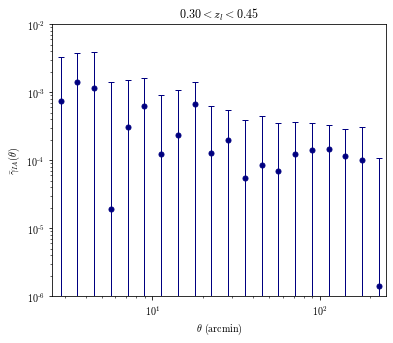

In [12]:
IA_var = np.zeros([nbins])
IA_jk = np.zeros(nbins)
for i in range(nbins):
    
    patches = IA_signal[:,i]
    IA_jk[i] = 1.0/npatches * np.sum(patches)
    
    # each row of GammaT_patches corresponds to an x_i estimate
    IA_var[i] = (npatches-1.0)/npatches * np.sum((patch - IA_jk[i])**2) # sum over x_i - x
    
IA_sig = np.sqrt(IA_var)

print(IA_sig)

plt.figure(figsize=[6,5])
plt.errorbar(theta_final, IA_final, yerr=IA_sig, lw=0, marker='o', color='navy', markersize=5, elinewidth=1, capsize=3)
plt.yscale('log')
plt.xscale('log')
plt.ylim([1e-6, 1e-2])
plt.xlim([2.5,250])
plt.xlabel(r'$\theta$ (arcmin)')
plt.ylabel(r'$\bar{\gamma}_{IA}(\theta)$')
plt.title(r'$0.30<z_{l}<0.45$')
plt.savefig('IA_prelim_measurement.png', dpi=300)